## Document Classification.

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv("shuffled-full-set-hashed.csv", header = None)
df.columns = ['Category', 'Content']
display(df.head())
print("Shape of data is : {}".format(df.shape))

,Category,Content
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


Shape of data is : (62204, 2)


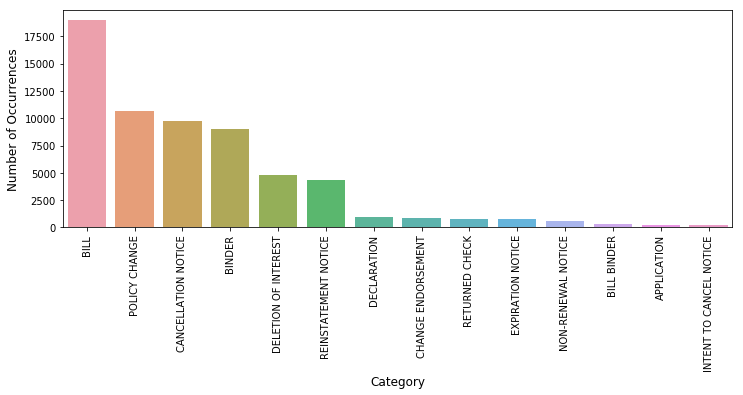

BILL                       18968
POLICY CHANGE              10627
CANCELLATION NOTICE         9731
BINDER                      8973
DELETION OF INTEREST        4826
REINSTATEMENT NOTICE        4368
DECLARATION                  968
CHANGE ENDORSEMENT           889
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
APPLICATION                  229
INTENT TO CANCEL NOTICE      229
Name: Category, dtype: int64


In [5]:
cnt_categories = df['Category'].value_counts()

plt.figure(figsize=(12,4))
g = sns.barplot(cnt_categories.index, cnt_categories.values, alpha=0.9)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)

plt.show()
print(cnt_categories)

In [6]:
# term frquency and document frequency vectorizer. Max_df and Min_df will filter out 
# terms that are very common(present in more than 44% of documents) or very rare(present in less than 1% documents)
# we will consider both 1 gram and 2 grams.
tfidf = TfidfVectorizer(sublinear_tf=True, max_df = 0.44, min_df = 0.01, norm='l2', ngram_range=(1, 2))

features = tfidf.fit_transform(df['Content'].values.astype('U')).toarray()
labels = df['Category']
features.shape

(62204, 3652)

In [7]:
N = 2
MAX = 4
i = 0
for Product, category_id in sorted(labels.items()):
    if i > MAX:
        break
    i = i + 1
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. 6b223a390d86
. d774c0d219f8
  . Most correlated bigrams:
. ba02159e05b1 892d541c89eb
. 6b223a390d86 6ce6cc5a3203
# '1':
  . Most correlated unigrams:
. 296e1c47e3cc
. 4bfcec3d7413
  . Most correlated bigrams:
. 75199e110c91 ff1c26ea0b6f
. eb562127f33e c0ed51271129
# '2':
  . Most correlated unigrams:
. d19b1c129f40
. 641356219cbc
  . Most correlated bigrams:
. f95d0bea231b 21e314d3afcc
. b9699ce57810 641356219cbc
# '3':
  . Most correlated unigrams:
. d19b1c129f40
. 641356219cbc
  . Most correlated bigrams:
. f95d0bea231b 21e314d3afcc
. b9699ce57810 641356219cbc
# '4':
  . Most correlated unigrams:
. d19b1c129f40
. 641356219cbc
  . Most correlated bigrams:
. f95d0bea231b 21e314d3afcc
. b9699ce57810 641356219cbc


In [8]:
# We will try a few models
models = [
    LinearSVC(),
    LogisticRegression(random_state=0),
]

# 5 fold cross validation
CV = 5

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warn

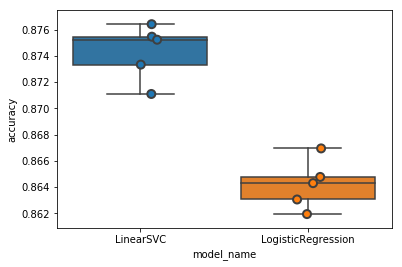

In [9]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [10]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [11]:
print(accuracy_score(y_test, y_pred))

0.8716341130134233


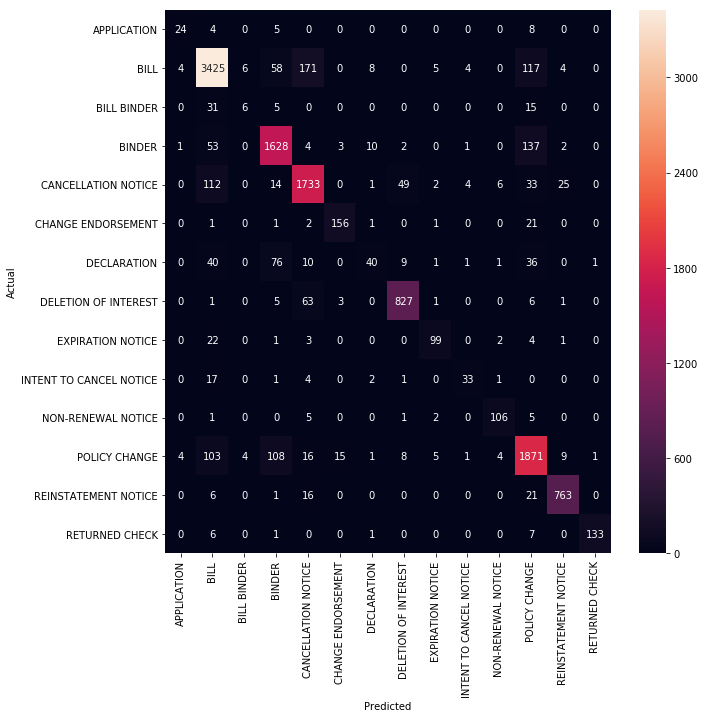

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
category_ids = df.groupby(['Category']).count().index
sns.heatmap(conf_mat, annot=True, fmt='d',
           xticklabels=category_ids, yticklabels=category_ids)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(df['Content'], df['Category'], random_state = 42, test_size=0.34)

### TfidfVectorizer
cv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')
features_train_cv = cv.fit_transform(features_train.values.astype('U'))

print("Feature Count\nCountVectorizer() #", len(cv.get_feature_names()))

selector = SelectKBest(chi2, k=1000)
selector.fit(features_train_cv, labels_train)

clf = LinearSVC()
clf.fit(selector.transform(features_train_cv), labels_train)


features_test_cv = cv.transform(features_test.values.astype('U'))
features_test_cv = selector.transform(features_test_cv)
pred = clf.predict(features_test_cv)
pred

Feature Count
CountVectorizer() # 3651


array(['BILL', 'BINDER', 'BILL', ..., 'CHANGE ENDORSEMENT',
       'CANCELLATION NOTICE', 'BILL'], dtype=object)

In [14]:
(features_train, labels_train) = (df['Content'].values.astype('U'), df['Category'])

### TfidfVectorizer
tfidfv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')

## Selector
selector = SelectKBest(chi2, k=1000)

linearsvc = Pipeline([('vect', tfidfv),
                ('selector', selector),
                ('clf', clf),
               ])
linearsvc.fit(features_train, labels_train)

from sklearn.externals import joblib
joblib.dump(linearsvc, 'model.pkl')

['model.pkl']

In [15]:
from sklearn.externals import joblib
joblib.dump(linearsvc, 'model_2.pkl', protocol=2)

['model_2.pkl']

In [16]:
classifier = open('model.pkl', 'rb')
model = joblib.load(classifier)

In [57]:
(features_train, labels_train) = (df.loc[1:400,'Content'].values.astype('U'), df.loc[1:400,'Category'])

### TfidfVectorizer
tfidfv = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.44, norm='l2')

## Selector
selector = SelectKBest(chi2, k=1000)

linear_svc = LinearSVC()

from sklearn.calibration import CalibratedClassifierCV

calibrated_svc = CalibratedClassifierCV(linear_svc, method='sigmoid') 

linearsvc = Pipeline([('vect', tfidfv),
                ('selector', selector),
                ('clf', calibrated_svc),
               ])
linearsvc.fit(features_train, labels_train)


c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.44, max_features=None, min_df=0.01,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tr...lty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='warn', method='sigmoid'))])

In [59]:
print(linearsvc.predict([df.iloc[1]['Content']]))
linearsvc.predict_proba([df.iloc[1]['Content']]).max()

['RETURNED CHECK']


0.7404794211208244

In [67]:
print(df.iloc[11]['Category'])
df.iloc[11]['Content']

POLICY CHANGE


'3d04e8a08335 2bcce4e05d9d 6bdb1352a45b 6d10c76d455a 0ade83d6e33b 11d62d3598ce 72edd8fbe1ba e3d00b97a972 c6697072927f a8bdacf47242 aa1ef5f5355f 9067496902b8 6b304aabdcee 8b0131ee1005 91f4b8acb0ae 2d1eaf147aaf 48a006082289 ed5d3a65ee2d 557ec6c63cf9 6bdb1352a45b 28b12e45914e a85c35f5a6c5 a5f8a7c9a886 8c4c99dc5cc9 6fd647aa15b8 54709b24b45f 1c303d15eb65 f1c9f7517642 df2af571cfeb 07315ce641ce e770f2684e5f f1c9f7517642 02bb5db84275 9bc65adc033c 6b304aabdcee 07315ce641ce 376aa3d8142d 6a01047db3ab 001acce69dc4 206d3b97caf4 3012dd989e4f 054cc375d1b7 dc44c7320e09 6f891ed8acef 40f3a08093c6 54709b24b45f 6101ed18e42f 40f08b0faecd abe7d2dd7c9b 5e99d31d8fa4 5c02c2aaa67b cc429363fb23 07315ce641ce c92f4cacc90e 35b44e45fb7c 25c57acdf805 c1a2676df403 35fa4eb616b6 6365c4563bd1 7ce149832ea7 bad6ff5dd7bc 5a94cb68e4cb a7b4f9d8ed3b 6365c4563bd1 f9402f006245 1015893e384a f95d0bea231b 6ce6cc5a3203 a38d7fa2201e cc429363fb23 580692541ca7 5c02c2aaa67b 07315ce641ce 07315ce641ce d12e70a0e113 97b6014f9e50 ce68d85c1b0

In [19]:
import pickle
import boto3

data_key = "model_light.pkl"
bucket = "document-classification"
s3 = boto3.resource('s3')
with open(data_key, 'wb') as data:
    s3.Bucket(bucket).download_fileobj(data_key, data)

with open(data_key, 'rb') as data:
    old_list = joblib.load(data)

ClientError: An error occurred (403) when calling the HeadObject operation: Forbidden

In [30]:
df.iloc[0]

Category                                 DELETION OF INTEREST
Content     e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
Name: 0, dtype: object

In [24]:
from sklearn.externals import joblib
classifier = open('model_light.pkl', 'rb')
model = joblib.load(classifier)